In [63]:
import selfies as sf
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import rdkit, rdkit.Chem, rdkit.Chem.Draw

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import Levenshtein

from tqdm import tqdm

In [2]:
# reading data
dataset_full = pd.read_csv(r'D:\projects\LSTM mol gen\dataJ_250k_rndm_zinc_drugs_clean.txt')
print("Total data size", len(dataset_full))
dataset_full.head()


Total data size 249455


,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
0,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
1,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
2,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...
3,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...
4,CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br


In [3]:
# smiles to selfies
selfies_list = [sf.encoder(s) for s in dataset_full.iloc[:, 0]]

In [4]:
print(selfies_list[0])

[C][C@@H1][C][C][Branch2][Ring1][Ring2][N][C][=C][N][=C][C][Branch1][=Branch2][C][=N][N][=C][N][Ring1][Branch1][C][=C][Ring1][N][C][C@@H1][Branch1][C][C][C][Ring2][Ring1][Ring2]


In [5]:
#parsing to create vocab
selfies_symbol_count = {"[nop]": 0}

def parse(s):
    for si in s.split("[")[1:]:
        token = "[" + si
        if token in selfies_symbol_count:
            selfies_symbol_count[token] += 1
        else:
            selfies_symbol_count[token] = 0
            
[parse(s) for s in selfies_list]

sorted_token_count = list(sorted(selfies_symbol_count.items(), key=lambda i: -i[1]))
for t in sorted_token_count[:10]:
    print(*t)

[C] 3533632
[=C] 1124758
[Ring1] 858765
[Branch1] 621080
[=Branch1] 523631
[N] 508933
[=O] 318168
[O] 279513
[Branch2] 202232
[Ring2] 177924


In [6]:
# dictionary of vocab and index
vocab = list(selfies_symbol_count.keys())
vocab_stoi = {o: i for o, i in zip(vocab, range(len(vocab)))}

# selfies to index 
def selfies2index(s):
    result = []
    for si in s.split("[")[1:]:
        result.append(vocab_stoi["[" + si])
    return result   

# index back to selfies
def index2selfies(v):
    return "".join([vocab[i] for i in v])


#testing conversions
s = selfies_list[0]
print("selfies :", s)
v = selfies2index(s)
print("selfies2index", v)
so = index2selfies(v)
print("index2selfies", so)

selfies : [C][C@@H1][C][C][Branch2][Ring1][Ring2][N][C][=C][N][=C][C][Branch1][=Branch2][C][=N][N][=C][N][Ring1][Branch1][C][=C][Ring1][N][C][C@@H1][Branch1][C][C][C][Ring2][Ring1][Ring2]
selfies2index [1, 2, 1, 1, 3, 4, 5, 6, 1, 7, 6, 7, 1, 8, 9, 1, 10, 6, 7, 6, 4, 8, 1, 7, 4, 6, 1, 2, 8, 1, 1, 1, 5, 4, 5]
index2selfies [C][C@@H1][C][C][Branch2][Ring1][Ring2][N][C][=C][N][=C][C][Branch1][=Branch2][C][=N][N][=C][N][Ring1][Branch1][C][=C][Ring1][N][C][C@@H1][Branch1][C][C][C][Ring2][Ring1][Ring2]


In [7]:
print(len(vocab))
print(vocab)

108
['[nop]', '[C]', '[C@@H1]', '[Branch2]', '[Ring1]', '[Ring2]', '[N]', '[=C]', '[Branch1]', '[=Branch2]', '[=N]', '[#C]', '[O]', '[=Branch1]', '[=O]', '[S]', '[#Branch1]', '[=Ring1]', '[Cl]', '[O-1]', '[C@H1]', '[#N]', '[NH1+1]', '[C@]', '[Br]', '[/C]', '[/O]', '[P]', '[NH1]', '[F]', '[=Ring2]', '[NH3+1]', '[#Branch2]', '[=S]', '[NH2+1]', '[C@@]', '[=N+1]', '[=NH1+1]', '[N+1]', '[\\C]', '[\\O]', '[/N]', '[/S]', '[\\S]', '[S@]', '[\\O-1]', '[N-1]', '[/NH1+1]', '[S@@]', '[=NH2+1]', '[/O-1]', '[S-1]', '[/S-1]', '[I]', '[\\N]', '[\\Cl]', '[=P]', '[/F]', '[/C@H1]', '[=OH1+1]', '[\\S-1]', '[=S@@]', '[/C@@H1]', '[=S@]', '[\\C@@H1]', '[/S@]', '[/Cl]', '[=N-1]', '[/N+1]', '[NH1-1]', '[\\NH1]', '[\\C@H1]', '[P@@H1]', '[P@@]', '[\\N-1]', '[-\\Ring1]', '[=P@@]', '[/NH1]', '[=PH2]', '[#N+1]', '[\\NH1+1]', '[P@]', '[P+1]', '[\\N+1]', '[-/Ring1]', '[S+1]', '[=O+1]', '[/N-1]', '[CH2-1]', '[=P@]', '[CH1-1]', '[=SH1+1]', '[/Br]', '[/C@@]', '[\\Br]', '[/C@]', '[/O+1]', '[=S+1]', '[\\F]', '[-/Ring2]', 

In [8]:
# pre-processing sequences
encoded_sequences = []
for seq in selfies_list:
    torch_tensor = torch.tensor(selfies2index(seq))
    encoded_sequences.append(torch_tensor)
    
encoded_seqs_sorted = sorted(encoded_sequences, key=lambda x: len(x), reverse=True)
padded_seqs = torch.nn.utils.rnn.pad_sequence(encoded_seqs_sorted, batch_first=True, padding_value=0)


In [9]:
# test padding 
import random
num_to_select = min(5, len(padded_seqs))
random_indices = random.sample(range(len(padded_seqs)), num_to_select)
for idx in random_indices:
    print(f"Sequence {idx}: Length={len(padded_seqs[idx])}, Content={padded_seqs[idx]}")


Sequence 150489: Length=72, Content=tensor([18,  1,  7,  1,  7, 15,  1,  3,  4,  1,  6,  1,  7,  1,  7,  1, 13,  5,
         7,  4, 13, 12,  1,  1, 12,  4, 16, 10,  1,  4, 15,  7,  5,  4,  5,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Sequence 69473: Length=72, Content=tensor([12,  7,  8,  1, 19,  1,  6,  1,  1,  8, 16,  1,  1,  1,  4, 13, 14,  1,
         1, 22,  8, 15,  1,  1,  7,  1,  7,  8,  1, 18,  1,  8,  1, 29,  7,  4,
         3,  1,  1,  5,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Sequence 172320: Length=72, Content=tensor([ 1,  1,  1, 12,  6,  7,  8,  1,  1,  1, 17, 13,  6,  1, 13,  1, 14,  6,
         1, 20,  1,  1, 12,  1,  7,  1,  7,  1,  7,  4, 13,  4, 32,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,

In [10]:
# creating dataset

class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        input_text, target_text = self.split_input_target(sequence)
        return input_text, target_text

    def split_input_target(self, sequence):
        if not isinstance(sequence, torch.Tensor):
            sequence = torch.tensor(sequence)
        input_text = torch.cat((torch.tensor([0]), sequence[:-1]), 0)
        target_text = sequence
        return input_text, target_text
    
    
dataset = SequenceDataset(padded_seqs)

In [11]:
# train / val split

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size    

train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 32

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_data,
                        batch_size=batch_size,
                        shuffle=False)

In [16]:
#hyperparameters
#vocab_size = len(vocab) 
#embedding_dim = 256  
#rnn_units = 128 

start_token = 0  
max_length = padded_seqs.shape[1]
temperature = 0.3

learning_rate = 0.001

class Config:
    vocab_size = len(vocab) 
    embedding_dim = 512
    rnn_units = 256
    
config = Config()

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size,embedding_dim, rnn_units):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.lstm = nn.LSTM(config.embedding_dim, config.rnn_units, batch_first=True)
        self.fc = nn.Linear(config.rnn_units, config.vocab_size)
    
    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, config.rnn_units).to(device),
                torch.zeros(1, batch_size, config.rnn_units).to(device))
# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(config.vocab_size, config.embedding_dim, config.rnn_units).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
def generate_sequence(model, start_token, max_length, temperature):
    model.eval()
    input_seq = torch.tensor([[start_token]], dtype=torch.long).to(device)
    hidden = model.init_hidden(1)
    generated_sequence = [start_token]

    for _ in range(max_length):
        output, hidden = model(input_seq, hidden)
        output = output / temperature
        probabilities = F.softmax(output[0, -1], dim=-1)
        next_token = torch.multinomial(probabilities, 1).item()
        generated_sequence.append(next_token)
        input_seq = torch.tensor([[next_token]], dtype=torch.long).to(device)
        if next_token == start_token:
            break
    
    return generated_sequence

In [17]:
import Levenshtein

def train(model, train_loader, val_loader, criterion, optimizer, epochs, config, device):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_edit_distances = []

        for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            hidden = model.init_hidden(inputs.size(0))
            outputs, _ = model(inputs, hidden)
            loss = criterion(outputs.view(-1, config.vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # Calculate Levenshtein Distance
            predicted = torch.argmax(outputs, dim=-1)
            for i in range(len(inputs)):
                reference = ''.join(map(str, targets[i].cpu().numpy().tolist()))
                candidate = ''.join(map(str, predicted[i].cpu().numpy().tolist()))
                edit_distance = Levenshtein.distance(reference, candidate)
                train_edit_distances.append(edit_distance)

        print(f"Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader)}, Training Levenshtein Distance: {np.mean(train_edit_distances)}")

        model.eval()
        val_loss = 0
        val_edit_distances = []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
                inputs, targets = inputs.to(device), targets.to(device)
                hidden = model.init_hidden(inputs.size(0))
                outputs, _ = model(inputs, hidden)
                loss = criterion(outputs.view(-1, config.vocab_size), targets.view(-1))
                val_loss += loss.item()
                
                # Calculate Levenshtein Distance
                predicted = torch.argmax(outputs, dim=-1)
                for i in range(len(inputs)):
                    reference = ''.join(map(str, targets[i].cpu().numpy().tolist()))
                    candidate = ''.join(map(str, predicted[i].cpu().numpy().tolist()))
                    edit_distance = Levenshtein.distance(reference, candidate)
                    val_edit_distances.append(edit_distance)
        
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}, Validation Levenshtein Distance: {np.mean(val_edit_distances)}")


# Train the model
epochs = 3
train(model, train_loader, val_loader, criterion, optimizer, epochs, config, device)

Training Epoch 1/3: 100%|██████████| 7016/7016 [01:42<00:00, 68.15it/s] 


Epoch 1, Training Loss: 0.5525297509801564, Training Levenshtein Distance: 15.195047859996704


Validation Epoch 1/3: 100%|██████████| 780/780 [00:04<00:00, 159.86it/s]


Epoch 1, Validation Loss: 0.4918381431545967, Validation Levenshtein Distance: 14.09805179187044


Training Epoch 2/3: 100%|██████████| 7016/7016 [01:18<00:00, 89.04it/s]


Epoch 2, Training Loss: 0.4686435184005049, Training Levenshtein Distance: 13.572725369584292


Validation Epoch 2/3: 100%|██████████| 780/780 [00:04<00:00, 160.44it/s]


Epoch 2, Validation Loss: 0.4574920707406142, Validation Levenshtein Distance: 13.406037040006414


Training Epoch 3/3: 100%|██████████| 7016/7016 [01:19<00:00, 88.74it/s]


Epoch 3, Training Loss: 0.44520954281822306, Training Levenshtein Distance: 13.023767421350591


Validation Epoch 3/3: 100%|██████████| 780/780 [00:04<00:00, 159.55it/s]

Epoch 3, Validation Loss: 0.44142563006816765, Validation Levenshtein Distance: 12.932454100857854


In [18]:
def draw_mols(example):
    example_selfies = index2selfies(example)
    exmaple_smiles = sf.decoder(example_selfies)
    #from rdkit import rdDepictor
    
    examples_mol = rdkit.Chem.MolFromSmiles(exmaple_smiles) 
    return rdkit.Chem.Draw.MolToImage(examples_mol)

[0, 1, 1, 1, 7, 1, 7, 3, 4, 10, 1, 6, 1, 13, 1, 14, 6, 1, 1, 6, 8, 10, 1, 13, 1, 14, 1, 7, 1, 7, 1, 7, 4, 13, 1, 1, 4, 7, 1, 7, 5, 4, 9, 0]


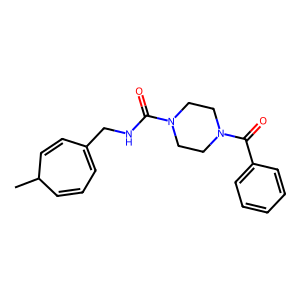

In [41]:
# Example usage
generated_sequence = generate_sequence(model, start_token, max_length, temperature=temperature)
print(generated_sequence)
draw_mols(generated_sequence)

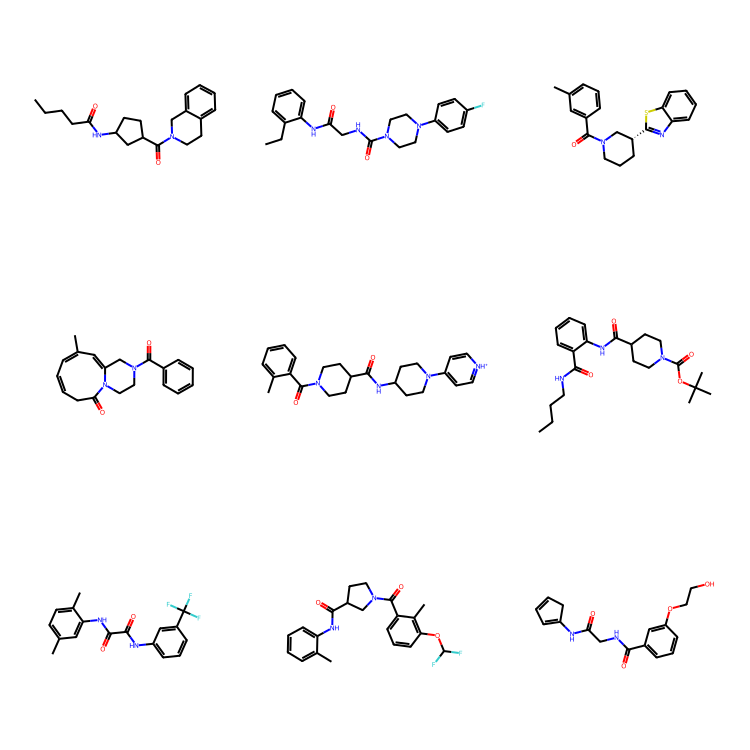

In [44]:
def draw_samples_grid():
    samples = []
    for i in range(9):
        generated_samples = generate_sequence(model, start_token, max_length, temperature=temperature)
        samples.append(generated_samples)
        
    selfies = [index2selfies(x) for x in samples]
    smiles = [sf.decoder(y) for y in selfies]   
    sample_mols = []
    for z in smiles:
        mol = rdkit.Chem.MolFromSmiles(z)
        sample_mols.append(mol)
    return rdkit.Chem.Draw.MolsToGridImage(sample_mols, molsPerRow = 3, subImgSize=(250,250))

draw_samples_grid()